In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np

# (Preparation) Clear data from outliers 

In [ ]:
data_files = [
    'data/09_groups.csv',
    'data/10_groups.csv',
    'data/11_groups.csv'
]

outliers = pd.read_csv("data/bad_ids.csv")

for f in data_files:
    df = pd.read_csv(f)
    clean_data = df[~df.id_card.isin(outliers.id_card)]
    
    clean_data.to_csv(f[:-4]+"_clean.csv")
    
    del(df)
    del(clean_data)

# Code beggins

In [3]:
clean_data_files = [
    'data/09_groups_clean.csv',
    'data/10_groups_clean.csv',
    'data/11_groups_clean.csv'
]

# TASK 1: 
## Prove that buying discounted products depends on the average order sum.

Or does it?

In [3]:
# We will work with september data
df = pd.read_csv(clean_data_files[0])
df.head(10)

,Unnamed: 0,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091
5,5,2020-09-01 12:47:31,1019873,0.0,375644,61,271,4.0,224.00,0,10091
6,6,2020-09-01 19:50:31,2487942,0.0,736538,61,97,1.0,56.00,0,10091
7,7,2020-09-01 18:40:04,8895052,0.0,142160,61,271,1.0,56.00,0,10091
8,8,2020-09-01 20:26:48,13354606,0.0,1408467,61,379,1.0,44.00,0,10091
9,9,2020-09-01 14:46:19,15422798,0.0,641525,61,97,1.0,56.00,0,10091


From all columns we need only `id_doc`, `sum`, `is_green`

In [4]:
df = df[['id_doc', 'sum', 'is_green']]

To check the dependence we first need to group our data by `id_doc` (check id) and find average sum of each order.

In [8]:
orders = df.groupby('id_doc').agg({'sum':'mean'})

Then we need to separate orders with green products from orders without green products

In [10]:
orders['green_count'] = df.groupby('id_doc').agg({'is_green':'sum'})['is_green']

In [29]:
green = orders[orders['green_count'] >= 1]
no_green = orders[orders['green_count'] < 1]

In [30]:
# small check that nothing is missed
assert len(orders) == (len(green) + len(no_green))

Having our data, we can formulate our hypothesis:
- $H_0$: The presence of green products does not depend on average sum of order. Therefore, both orders with green and without green products has same expected average sum.
- $H_a$: There is no dependence. Therefore, the expected value of average sum will differ for orders with green and without green products.

### Method 1: visual

<AxesSubplot:xlabel='sum', ylabel='green_count'>

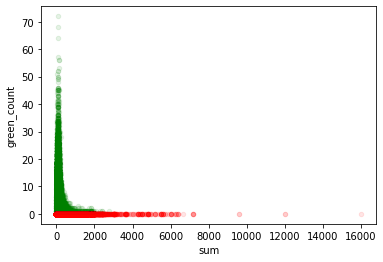

In [28]:
ax = green.plot.scatter('sum', 'green_count', color='g', alpha=0.1)
no_green.plot.scatter('sum', 'green_count', color='r', alpha=0.1, ax=ax)

Text(0.5, 1.0, 'No green')

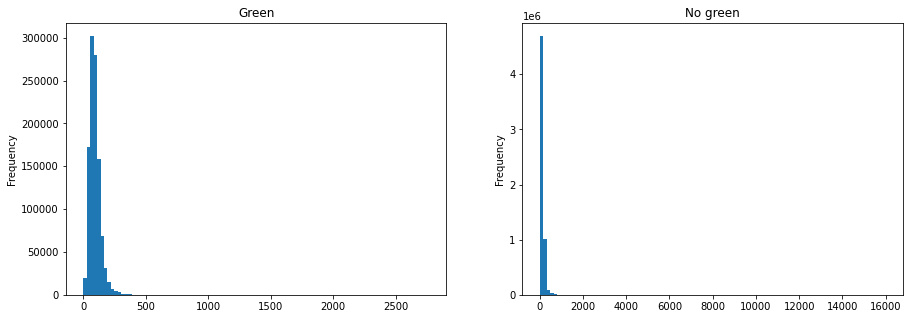

In [52]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
green['sum'].plot.hist(bins=100)
plt.title("Green")
plt.subplot(1,2,2)
no_green['sum'].plot.hist(bins=100)
plt.title("No green")

From the plot above, it is hard to say how much expected values of two samples differ. 

### Method 2: two-sample test
As the mean values tend to distribute normally, we can apply two-sample test to test our null hyposesis that samples has same expected value.

Let green orders be $X$, no_green - $Y$

$T = \frac{\bar{X} - \bar{Y}}{\sqrt{\frac{S_X^2}{N_X} + \frac{S_Y^2}{N_Y}}}$

Note that we cannot assume that samples has same std.

In [58]:
X_mean = green['sum'].mean()
Y_mean = no_green['sum'].mean()
Sx = green['sum'].std()
Sy = no_green['sum'].std()
Nx = len(green)
Ny = len(no_green)

T = (X_mean-Y_mean)/(math.sqrt(Sx**2/Nx + Sy**2/Ny))

In [59]:
T

-553.5078221065652

Accordinf to [t_table](https://www.sjsu.edu/faculty/gerstman/StatPrimer/t-table.pdf), for df  $ \to \infty$, our T value indicates p value close to 0.

This is an strong evidence to reject our $H_0$, meanung that there IS significant difference between expected values of these samples.

More specisically, the negative sign of our T value indicates that 
$$\bar{Y} > \bar{X}$$

**Verdict: We have evidence, that there is dependence between average order sum and appearance of discoun products. More precisely, it could be said that with larger average order sum the probability of green product purchase drops.**

# TASK 2: 
## Prove that the frequency of shopping grows around the wage taking days

Or does it?

In [3]:
# We will work with september data
df = pd.read_csv(clean_data_files[0])
df.head(10)

,Unnamed: 0,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091
5,5,2020-09-01 12:47:31,1019873,0.0,375644,61,271,4.0,224.00,0,10091
6,6,2020-09-01 19:50:31,2487942,0.0,736538,61,97,1.0,56.00,0,10091
7,7,2020-09-01 18:40:04,8895052,0.0,142160,61,271,1.0,56.00,0,10091
8,8,2020-09-01 20:26:48,13354606,0.0,1408467,61,379,1.0,44.00,0,10091
9,9,2020-09-01 14:46:19,15422798,0.0,641525,61,97,1.0,56.00,0,10091


In [4]:
df.index = pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')

We need only `id_doc`

In [5]:
df = df[['id_doc']]

Now we count number of checks per day

In [11]:
check_count = df.groupby(df.index.day).agg({'id_doc':'nunique'})

Text(0.5, 1.0, 'September')

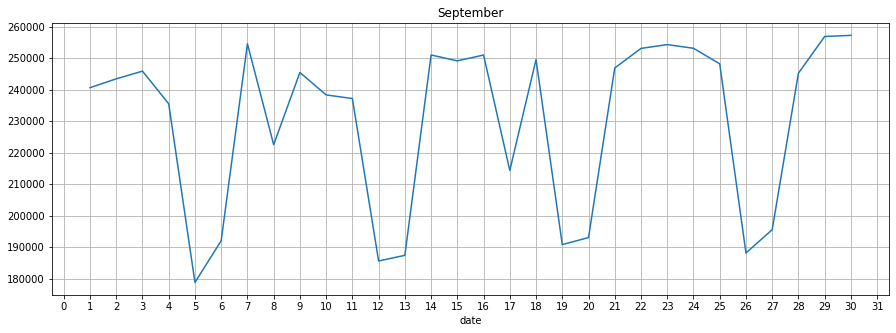

In [24]:
plt.figure(figsize=(15,5))
plt.locator_params(axis="x", nbins=50)
check_count['id_doc'].plot()
plt.grid()
plt.title("September")

There is kind of growing trend for frequence increase from the begining of month to its end. Better to get more data

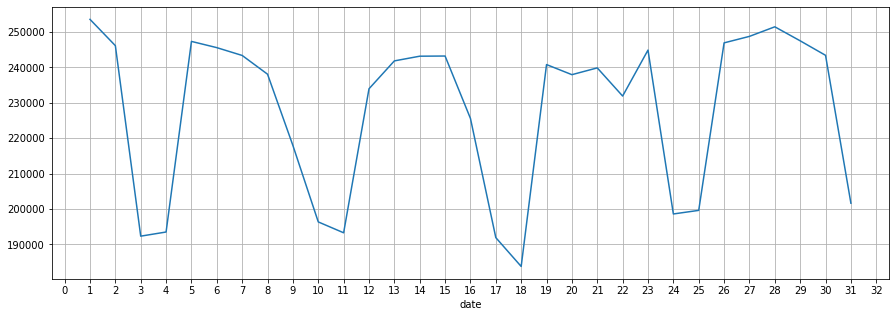

In [25]:
del(df)
df = pd.read_csv(clean_data_files[1])
df = df[['id_doc', 'date']]
df.index = pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')
check_count = df.groupby(df.index.day).agg({'id_doc':'nunique'})
plt.figure(figsize=(15,5))
plt.locator_params(axis="x", nbins=50)
check_count['id_doc'].plot()
plt.grid()

^ October
Here is visible trend for frequency reduction untill 20th of October and subsequent groth

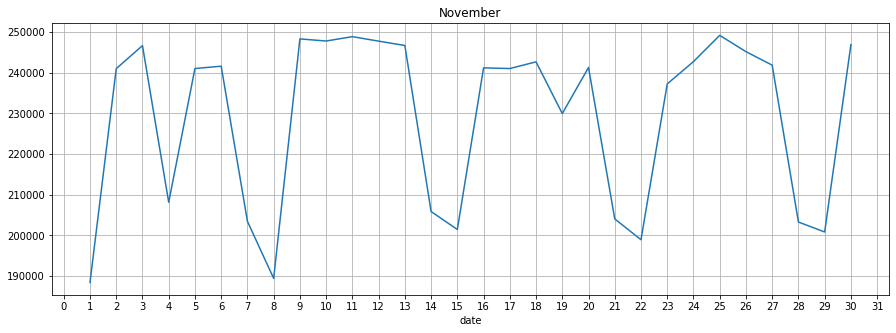

In [26]:
del(df)
df = pd.read_csv(clean_data_files[2])
df = df[['id_doc', 'date']]
df.index = pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')
check_count = df.groupby(df.index.day).agg({'id_doc':'nunique'})
plt.figure(figsize=(15,5))
plt.locator_params(axis="x", nbins=50)
check_count['id_doc'].plot()
plt.title("November")
plt.grid()

Here no trend present

**Verdict: There is clear dependence of frequency on day of the week (there are less orders on Fridays and Saturdays), but around wage taking days there is no significant growth that is standing out.**

# TASK 3.1:
## Frequent buyers - The users that are shopping daily

In [3]:
# We will work with september data
df = pd.read_csv(clean_data_files[0])
df.head(10)

,Unnamed: 0,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091
5,5,2020-09-01 12:47:31,1019873,0.0,375644,61,271,4.0,224.00,0,10091
6,6,2020-09-01 19:50:31,2487942,0.0,736538,61,97,1.0,56.00,0,10091
7,7,2020-09-01 18:40:04,8895052,0.0,142160,61,271,1.0,56.00,0,10091
8,8,2020-09-01 20:26:48,13354606,0.0,1408467,61,379,1.0,44.00,0,10091
9,9,2020-09-01 14:46:19,15422798,0.0,641525,61,97,1.0,56.00,0,10091


In [4]:
df.index = pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')
df['day'] = df.index.date

We need only `date`, `id_doc`, `id_card`

In [5]:
df = df[['day', 'id_doc', 'id_card']]

Count number of checks for each card for each day

In [6]:
df = df.groupby(['day', 'id_card']).agg({'id_doc':'nunique'})

In [8]:
df = df.reset_index()

In [16]:
deltas = df.groupby('id_card').apply(lambda x: [delta.days for delta in np.diff(sorted(set(x['day'])))])

Text(0, 0.5, 'People count')

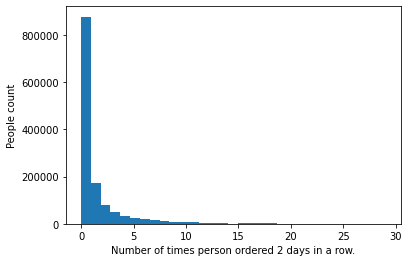

In [24]:
daily_castomers = deltas.apply(lambda x: len([delta for delta in x if delta == 1]))
daily_castomers.plot.hist(bins=31)
plt.xlabel('Number of times person ordered 2 days in a row.')
plt.ylabel('People count')

From this histogram, it is visible that there are people who has more than 15 times, then they returned to store on next day, meaning they were "dayly" customes 15 times, attending store 16+ times. 
Although, there a lot of people who has never returned to store on the next day (first bin)

<AxesSubplot:ylabel='Frequency'>

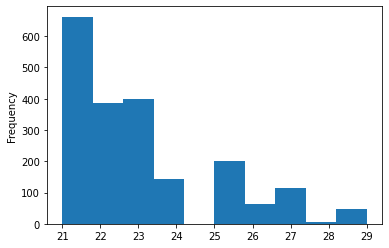

In [32]:
daily_castomers[daily_castomers > 20].plot.hist(bins=10)

**Here are customers, that could be called 'daily castomers'**

# TASK 3.2
## Average purchase sum - the customers that usually spend the same amount of money 

In [3]:
# We will work with september data
df = pd.read_csv(clean_data_files[0])
df.head(10)

,Unnamed: 0,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091
5,5,2020-09-01 12:47:31,1019873,0.0,375644,61,271,4.0,224.00,0,10091
6,6,2020-09-01 19:50:31,2487942,0.0,736538,61,97,1.0,56.00,0,10091
7,7,2020-09-01 18:40:04,8895052,0.0,142160,61,271,1.0,56.00,0,10091
8,8,2020-09-01 20:26:48,13354606,0.0,1408467,61,379,1.0,44.00,0,10091
9,9,2020-09-01 14:46:19,15422798,0.0,641525,61,97,1.0,56.00,0,10091


In [4]:
df = df[['id_doc', 'id_card', 'sum']]

Aggregate the total sum for each order of customers

In [7]:
df = df.groupby(['id_doc', 'id_card']).agg({'sum':'sum'})
df = df.reset_index()

Calculate the variance of order total sum for each customer

In [12]:
stds = df.groupby('id_card').apply(lambda x: x['sum'].std())

<AxesSubplot:ylabel='Frequency'>

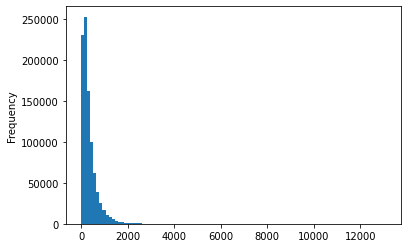

In [14]:
stds.plot.hist(bins = 100)

We are interested in people with as less std as possible:
Assumind that sum is in rubles, 10 ruble std seems good (var then is 100 rub)

<AxesSubplot:ylabel='Frequency'>

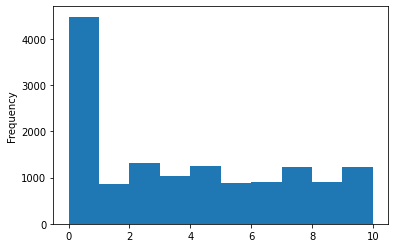

In [19]:
stds[stds < 10].plot.hist(bins = 10)

There are actually people with 0 std

In [16]:
stds[stds == 0]

id_card
1577       0.0
2078       0.0
3775       0.0
4760       0.0
5514       0.0
          ... 
1927215    0.0
1927860    0.0
1928450    0.0
1929064    0.0
1931196    0.0
Length: 3720, dtype: float64

**That is the way to find people, who spend the same amount of money from one purchase to another**

# TASK 3.3
## Usual cart - The customers grouped by the product groups

In [4]:
# We will work with september data
df = pd.read_csv(clean_data_files[0])
df.head(10)

,Unnamed: 0,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091
5,5,2020-09-01 12:47:31,1019873,0.0,375644,61,271,4.0,224.00,0,10091
6,6,2020-09-01 19:50:31,2487942,0.0,736538,61,97,1.0,56.00,0,10091
7,7,2020-09-01 18:40:04,8895052,0.0,142160,61,271,1.0,56.00,0,10091
8,8,2020-09-01 20:26:48,13354606,0.0,1408467,61,379,1.0,44.00,0,10091
9,9,2020-09-01 14:46:19,15422798,0.0,641525,61,97,1.0,56.00,0,10091


In [5]:
df = df[['id_card', 'id_group', 'id_doc']]

In [9]:
groups = df.groupby(['id_group', 'id_card']).agg({'id_doc':'count'})
groups = groups.reset_index()

Here we can see the frequencies of orders containing specific groups of groducts for each customer. Therefore, we can find people who frequently buy specific group.

Example: for group 10004

<AxesSubplot:ylabel='Frequency'>

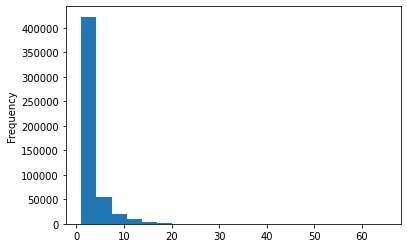

In [13]:
groups[groups['id_group'] == 10004]['id_doc'].plot.hist(bins=20)

In [14]:
groups[(groups['id_group'] == 10004) & (groups['id_doc'] > 20)]

,id_group,id_card,id_doc
630926,10004,135,21
631074,10004,637,27
631091,10004,673,29
631110,10004,715,24
632113,10004,3180,21
...,...,...,...
1139119,10004,1901200,26
1139975,10004,1905775,21
1141060,10004,1911237,22
1141555,10004,1913934,23


**This is the way to find customers that frequently buys sertain group of products**